# Computer Vision 2024 Assignment 2: Image matching and retrieval

In this prac, you will experiment with image feature detectors, descriptors and matching. There are 3 main parts to the prac:

- matching an object in a pair of images
- searching for an object in a collection of images
- analysis and discussion of results

## General instructions

As before, you will use this notebook to run your code and display your results and analysis. Again we will mark a PDF conversion of your notebook, referring to your code if necessary, so you should ensure your code output is formatted neatly. 

***When converting to PDF, include the outputs and analysis only, not your code.*** You can do this from the command line using the `nbconvert` command (installed as part of Jupyter) as follows:

    jupyter nbconvert Assignment2.ipynb --to pdf --no-input --TagRemovePreprocessor.remove_cell_tags 'remove-cell'

This will also remove the preamble text from each question. It has been packaged into a small notebook you can run in colab, called notebooktopdf.ipynb


We will use the `OpenCV` library to complete the prac. It has several built in functions that will be useful. You are expected to consult documentation and use them appropriately.

As with the last assignment it is somewhat up to you how you answer each question. Ensure that the outputs and report are clear and easy to read so that the markers can rapidly assess what you have done, why, and how deep is your understanding. This includes:

- sizing, arranging and captioning image outputs appropriately
- explaining what you have done clearly and concisely
- clearly separating answers to each question

## Data

We have provided some example images for this assignment, available through a link on the MyUni assignment page. The images are organised by subject matter, with one folder containing images of book covers, one of museum exhibits, and another of urban landmarks. You should copy these data into a directory A2_smvs, keeping the directory structure the same as in the zip file.  

Within each category (within each folder), there is a “Reference” folder containing a clean image of each object and a “Query” folder containing images taken on a mobile device. Within each category, images with the same name contain the same object (so 001.jpg in the Reference folder contains the same book as 001.jpg in the Query folder).
The data is a subset of the Stanford Mobile Visual Search Dataset which is available at 

<http://web.cs.wpi.edu/~claypool/mmsys-dataset/2011/stanford/index.html>. 

The full data set contains more image categories and more query images of the objects we have provided, which may be useful for your testing!

Do not submit your own copy of the data or rename any files or folders! For marking, we will assume the datasets are available in subfolders of the working directory using the same folder names provided.

Here is some general setup code, which you can edit to suit your needs.

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# !pwd
# %cd drive/MyDrive/Colab\ Notebooks
# !pwd

In [ ]:
# NTS: DELETE THIS BEFORE SUBMITTING
# We look for queryImage in trainImage (accdgt to cv2 documentation) -> reference is query, and query is train.

In [12]:
# Numpy is the main package for scientific computing with Python. 
import numpy as np
import cv2
import os
# Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt
# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots, can be changed
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def draw_outline(ref, query, model):
    """
        Draw outline of reference image in the query image.
        This is just an example to show the steps involved.
        You can modify to suit your needs.
        Inputs:
            ref: reference image
            query: query image
            model: estimated transformation from query to reference image
    """
    h,w = ref.shape[:2]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,model)
    
    img = query.copy()
    img = cv2.polylines(img,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    plt.imshow(img, 'gray'), plt.show()

def draw_inliers(img1, img2, kp1, kp2, matches, matchesMask):
    """
        Draw inlier between images
        img1 / img2: reference/query  img
        kp1 / kp2: their keypoints
        matches : list of (good) matches after ratio test
        matchesMask: Inlier mask returned in cv2.findHomography() 
    """
    matchesMask = matchesMask.ravel().tolist()
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                    singlePointColor = None,
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,**draw_params)
    plt.imshow(img3, 'gray'),plt.show()


# Question 1: Matching an object in a pair of images (60%)


In this question, the aim is to accurately locate a reference object in a query image, for example:

![Books](book.png "Books")

0. Download and read through the paper [ORB: an efficient alternative to SIFT or SURF](https://www.researchgate.net/publication/221111151_ORB_an_efficient_alternative_to_SIFT_or_SURF) by Rublee et al. You don't need to understand all the details, but try to get an idea of how it works. ORB combines the FAST corner detector (covered in week 3) and the BRIEF descriptor. BRIEF is based on similar ideas to the SIFT descriptor we covered week 3, but with some changes for efficiency.

1. [Load images] Load the first (reference, query) image pair from the "book_covers" category using opencv (e.g. `img=cv2.imread()`). Check the parameter option in "
cv2.imread()" to ensure that you read the gray scale image, since it is necessary for computing ORB features.

2. [Detect features] Create opencv ORB feature extractor by `orb=cv2.ORB_create()`. Then you can detect keypoints by `kp = orb.detect(img,None)`, and compute descriptors by `kp, des = orb.compute(img, kp)`. You need to do this for each image, and then you can use `cv2.drawKeypoints()` for visualization.

3. [Match features] As ORB is a binary feature, you need to use HAMMING distance for matching, e.g., `bf = cv2.BFMatcher(cv2.NORM_HAMMING)`. Then you are requried to do KNN matching (k=2) by using `bf.knnMatch()`. After that, you are required to use "ratio_test" to find good matches. By default, you can set `ratio=0.8`.

4. [Plot and analyze] You need to visualize the matches by using the `cv2.drawMatches()` function. Also you can change the ratio values, parameters in `cv2.ORB_create()`, and distance functions in `cv2.BFMatcher()`. Please discuss how these changes influence the match numbers.


## Load image pair

In [20]:
# load images as grey scale
# edit PATH
# PATH = "."
PATH = os.getcwd() + r'/Assignment 2/Assignment2'
img1 = cv2.imread(PATH + '/A2_smvs/book_covers/Reference/001.jpg', 0)
if not np.shape(img1):
  # Error message and print current working dir
  print("Could not load img1. Check the path, filename and current working directory\n")
  !pwd
img2 = cv2.imread(PATH + "/A2_smvs/book_covers/Query/001.jpg", 0)
if not np.shape(img2):
  # Error message and print current working dir
  print("Could not load img2. Check the path, filename and current working directory\n")
  !pwd

## Baseline ORB Feature Extractor and Feature Matching 

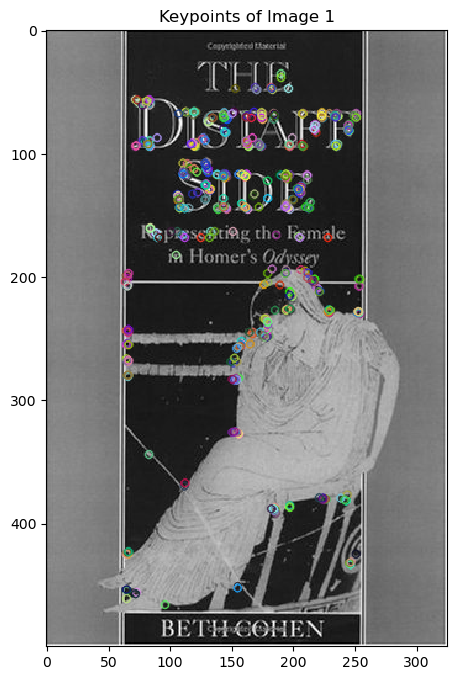

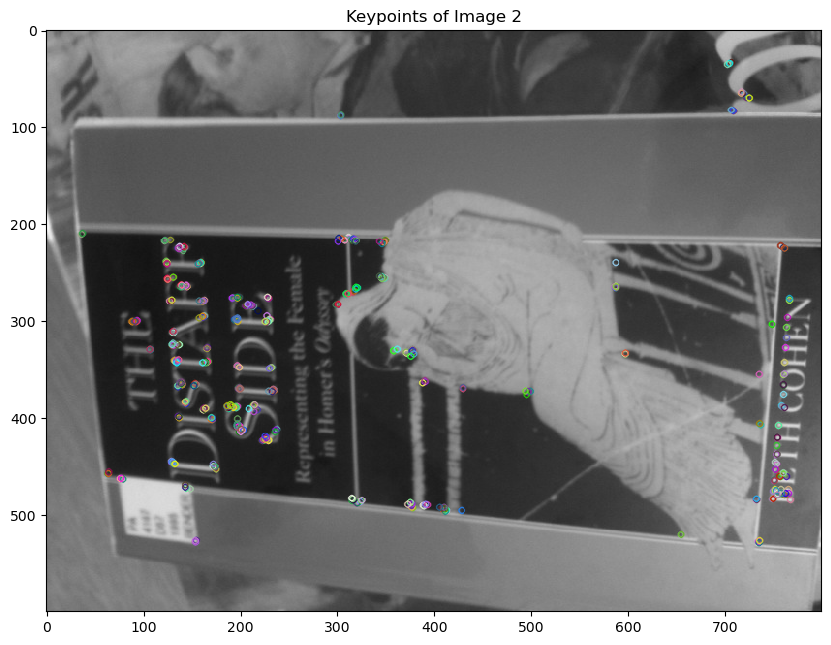

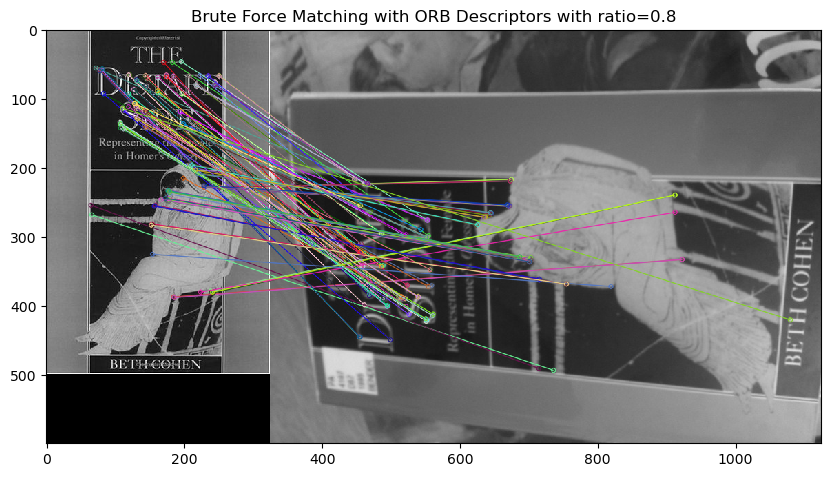

In [21]:
# Your code for descriptor matching tests here
# compute detector and descriptor, see (2) above
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB, see (2) above
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# draw keypoints, see (2) above
# draw img1
plt.imshow(cv2.drawKeypoints(img1, kp1, 0))
plt.title("Keypoints of Image 1")
plt.show()
# draw img2
plt.imshow(cv2.drawKeypoints(img2, kp2, 0))
plt.title("Keypoints of Image 2")
plt.show()

# create BFMatcher object, see (3) above
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors, see (3) above
matches = bf.knnMatch(des1, des2, k = 2)

# Apply ratio test, see (3) above
ratio = 0.8
good = []
for m,n in matches:
    if m.distance < ratio * n.distance:
        good.append([m])
    
# draw matches, see (4) above
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.title(f"Brute Force Matching with ORB Descriptors with {ratio=}") 
plt.imshow(img3)

### Changing Ratio Values for Ratio Test

In [61]:
def ORB_with_BFMatching(img1 = img1, img2 = img2, ratio = 0.8, distance = cv2.NORM_HAMMING, kwargs = {}):
    # Your code for descriptor matching tests here
    # compute detector and descriptor, see (2) above
    if not kwargs:
        orb = cv2.ORB_create()
    else:
        orb = cv2.ORB_create(kwargs)
    # find the keypoints and descriptors with ORB, see (2) above
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    # # draw keypoints, see (2) above
    # # draw img1
    # plt.imshow(cv2.drawKeypoints(img1, kp1, 0))
    # plt.title("Keypoints of Image 1")
    # plt.show()
    # # draw img2
    # plt.imshow(cv2.drawKeypoints(img2, kp2, 0))
    # plt.title("Keypoints of Image 2")
    # plt.show()
    # create BFMatcher object, see (3) above
    bf = cv2.BFMatcher(distance)
    # Match descriptors, see (3) above
    matches = bf.knnMatch(des1, des2, k = 2)

    # Apply ratio test, see (3) above
    good = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])
        
    # draw matches, see (4) above
    img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    print(f"ORB_create() parameters: {kwargs}" if kwargs else "No parameters passed to ORB_create()")
    print('-' * 10)
    print(f"Number of total matches={len(matches)}")
    print(f"Number of matches within threshold={len(good)}")
    plt.title(f"Brute Force Matching with ORB Descriptors with {ratio=} and Distance Function {distance=}") 
    plt.imshow(img3)

No parameters passed to ORB_create()
----------
Number of total matches=500
Number of matches within threshold=469


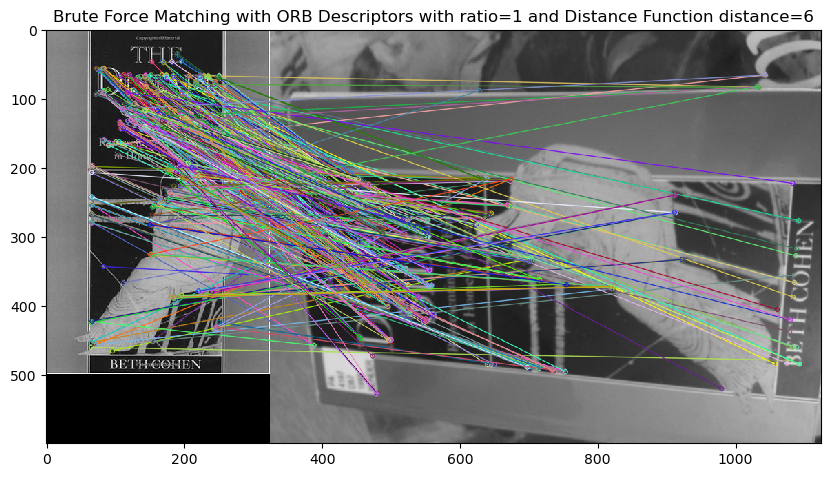

In [62]:
ORB_with_BFMatching(img1, img2, 1)

No parameters passed to ORB_create()
----------
Number of total matches=500
Number of matches within threshold=242


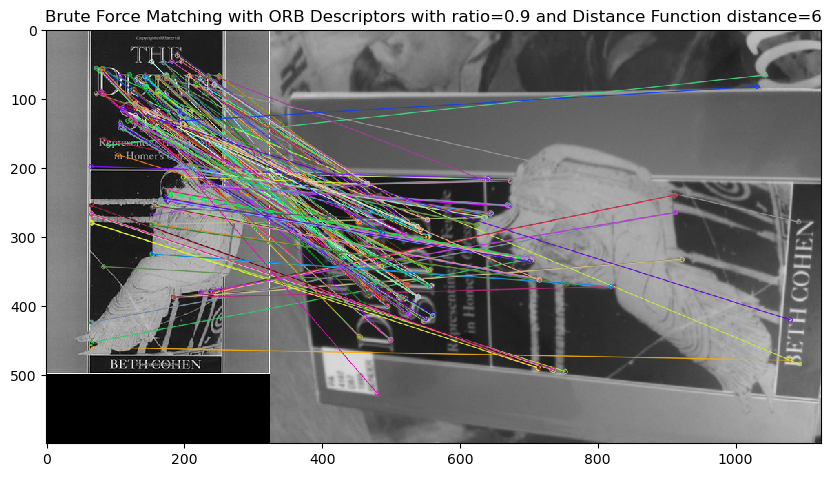

In [63]:
ORB_with_BFMatching(img1, img2, 0.9)

No parameters passed to ORB_create()
----------
Number of total matches=500
Number of matches within threshold=19


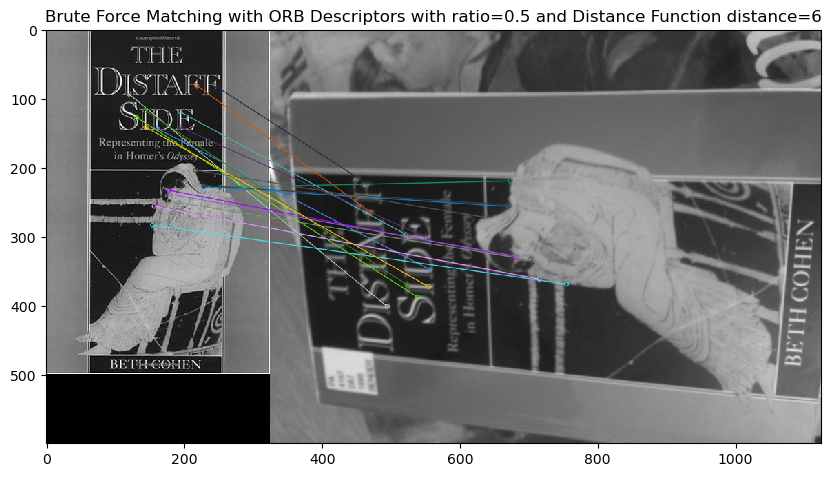

In [64]:
ORB_with_BFMatching(img1, img2, 0.5)

No parameters passed to ORB_create()
----------
Number of total matches=500
Number of matches within threshold=1


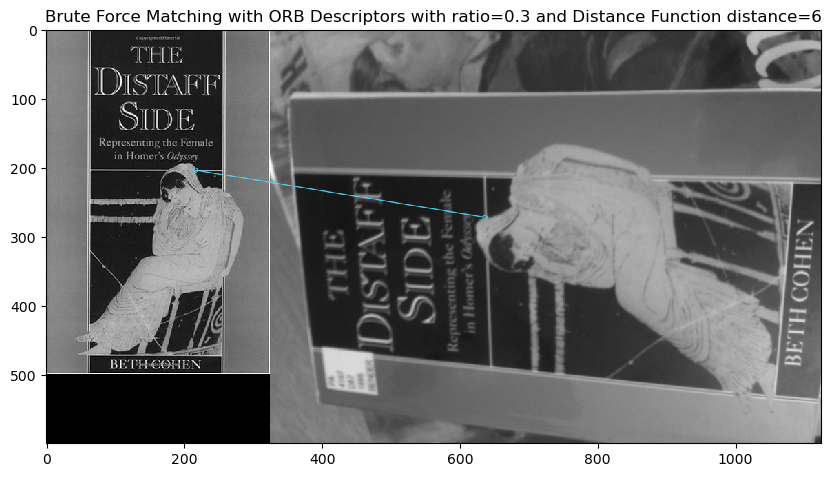

In [65]:
ORB_with_BFMatching(img1, img2, 0.3)

***Explanation***

In the paper ["Distinctive Image Features from Scale-Invariant Keypoints"](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), Lowe explained that Keypoint matching can be effectively done by measuring the closest and second-closest neighbor's distance from the candidate point. Below is the graph of the PDFs of correct and incorrect matches of the keypoints with respect to ratio levels.

<img src="/Users/nic/Uni/CS7315/Assignment 2/Assignment2/SCR-20240705-npro.png" style="width: 30%; height: auto;">

In the experimentation above, we see that that at higher ratios (closer to 1) of the ratio-test, there would exist more matches between the query and reference as supported by the graph above, but this means that there are much more incorrect matches. As the ratios get closer to 0, we see that the number of matches decrease, but the number of incorrect matches decreased. This can be also seen in the graph above. We can see that a lower ratio value implies a "stricter" matching criteria to prevent false positive matches since we want to check which distances are close enough given a threshold multiplier.

### Changing ORB paremeters

### Changing Distance Function

No parameters passed to ORB_create()
Number of matches=131


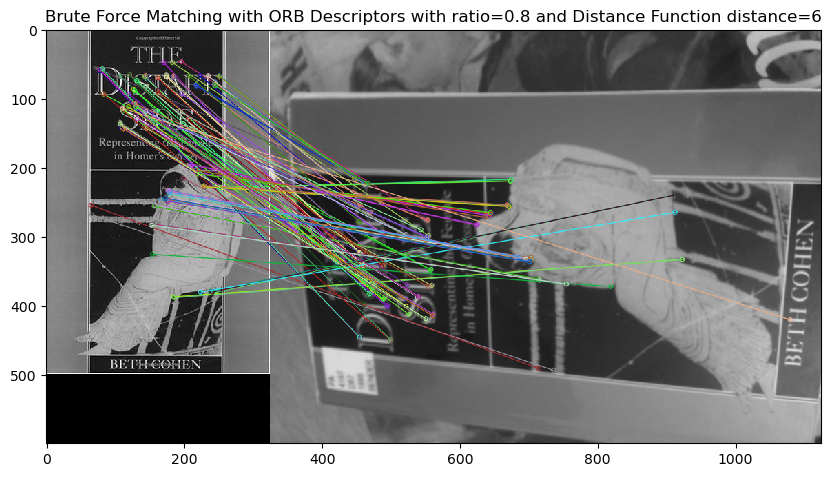

In [51]:
# Hamming Distance
ORB_with_BFMatching(img1=img1, img2=img2, distance=cv2.NORM_HAMMING)

No parameters passed to ORB_create()
Number of matches=109


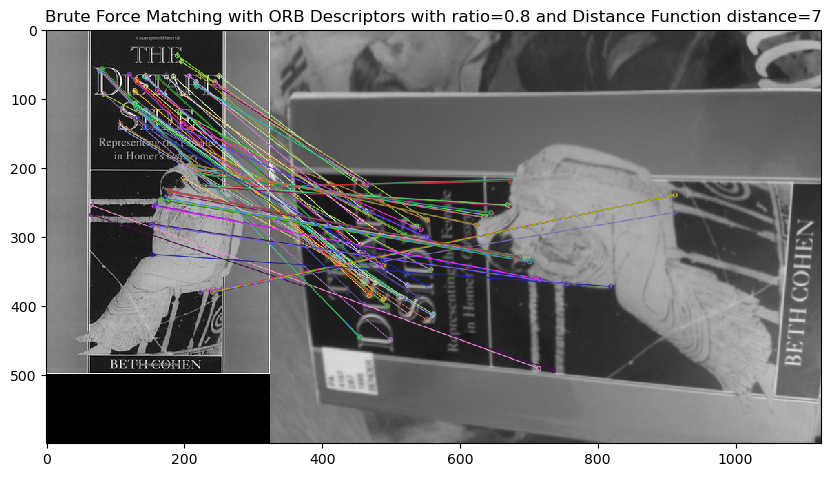

In [52]:
# Hamming2 Distance
ORB_with_BFMatching(img1=img1, img2=img2, distance=cv2.NORM_HAMMING2)

No parameters passed to ORB_create()
----------
Number of total matches=500
Number of matches within threshold=51


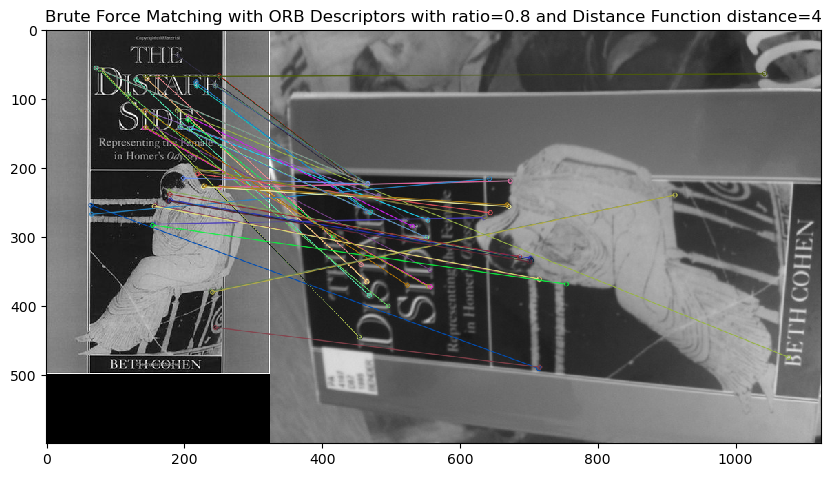

In [66]:
# L2 Distance
ORB_with_BFMatching(img1=img1, img2=img2, distance=cv2.NORM_L2)

***Explanation***

It can be observed that the ORB descriptors are binary. This means that other distance functions such as L1 and L2 norm might not be particularly appropriate given their definitions. It is common convention to use Hamming or Hamming2 (which accounts for rotation invariance) and both account for difference in bit positions given binary strings. While not necessarily different distance functions (strictly speaking), Hamming2 is more appropriate when considering features that are rotationally invariant. In the example above, we can see that number of matches  within the threshold decreased from Hamming to Hamming2 and the number of good matches. Moreover, we see that the L2 norm performed the worst compared to the using Hamming Distances.

## Homography

5. Estimate a homography transformation based on the matches, using `cv2.findHomography()`. Display the transformed outline of the first reference book cover image on the query image, to see how well they match.

    - We provide a function `draw_outline()` to help with the display, but you may need to edit it for your needs.
    - Try the 'least squre method' option to compute homography, and visualize the inliers by using `cv2.drawMatches()`. Explain your results.
    - Again, you don't need to compare results numerically at this stage. Comment on what you observe visually.

### Least Squares Method

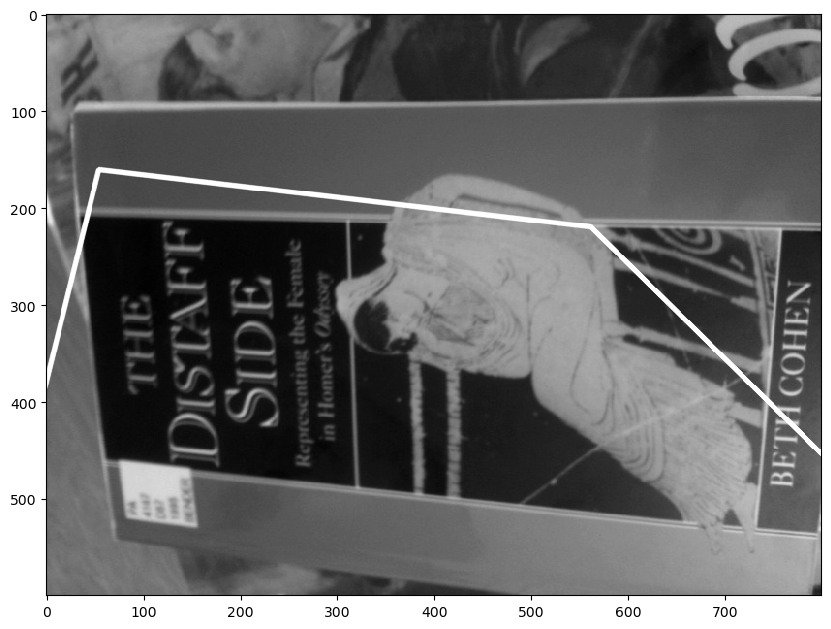

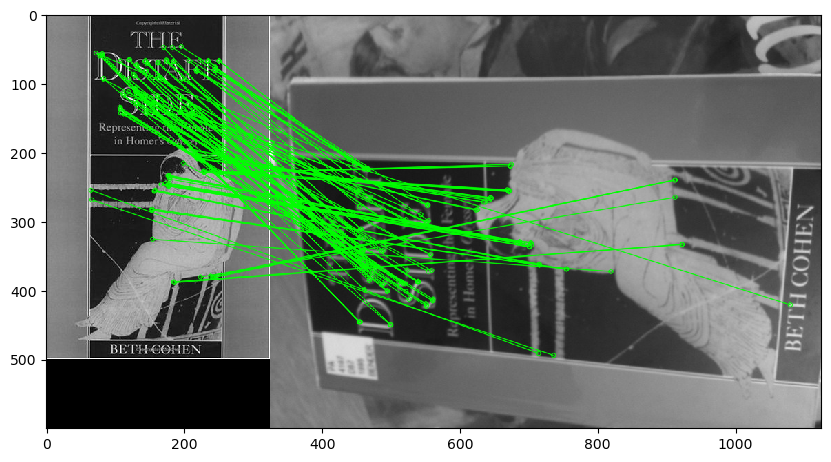

In [9]:
# Code adapted from: https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

# Define a minimum number of of matches needed
min_match_count = 10
if len(good) >= min_match_count:
    # Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
    src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

    # using cv2 standard method, see (3) above
    # value of 0 uses the least squares bethod. 
    M, mask = cv2.findHomography(src_pts, dst_pts, method=0)
    # draw frame
    draw_outline(img1, img2, M)
    # draw inliers
    draw_inliers(img1,img2, kp1, kp2, [m[0] for m in good], mask)
else:
    print("Not enough matches are found; Matches: {}, Minimum Needed: {}".format(len(good), min_match_count))


In [10]:
# TO-DO: yap

***Your explanation of results here***

### RANSAC Method

Try the RANSAC option to compute homography. Change the RANSAC parameters, and explain your results. Print and analyze the inlier numbers.

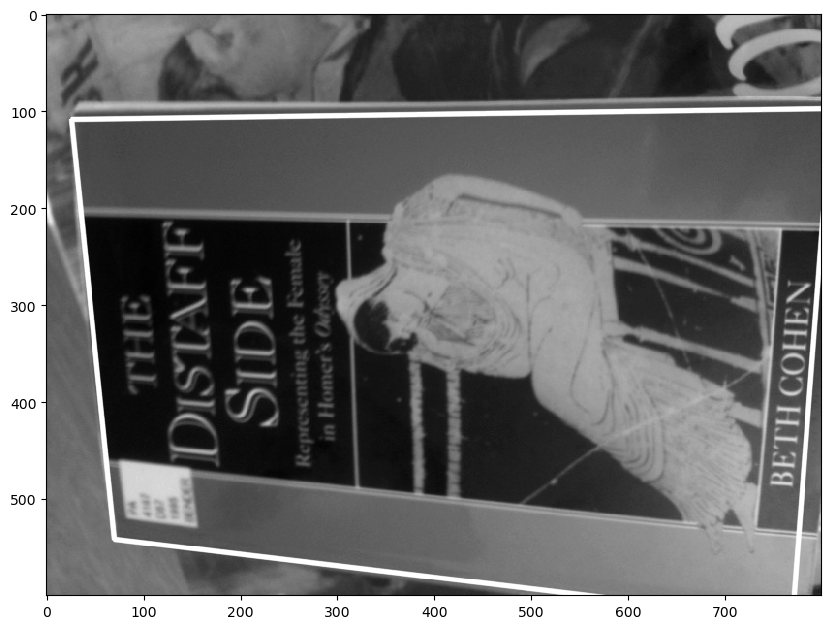

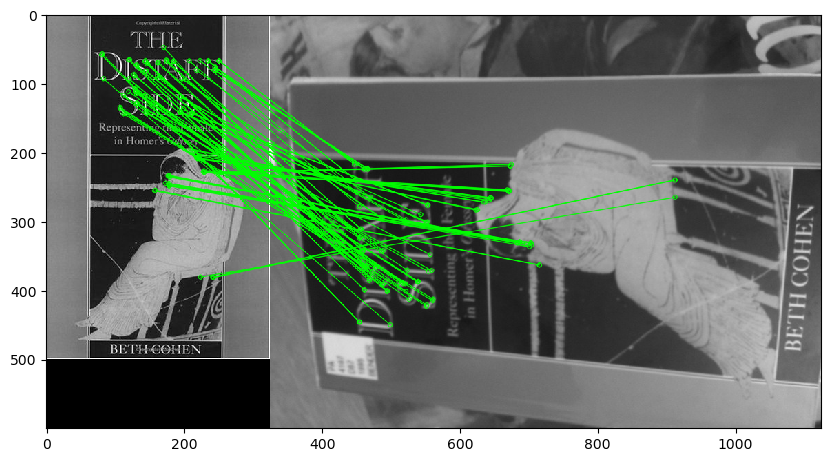

Inlier Count: 100


In [11]:
# Using RANSAC
M_ransac, mask_ransac = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5)
# draw frame
draw_outline(img1, img2, M_ransac)
# draw inliers
draw_inliers(img1,img2, kp1, kp2, [m[0] for m in good], mask_ransac)

# inlier number
print(f"Inlier Count: {sum(mask_ransac.ravel().tolist())}")

The main pararmeter in consideration would be the ransacReprojThreshold is given by the formula:

$\left\| \text{dstPoints}_i - \text{convertPointsHomogeneous}(\mathbf{H} \cdot \text{srcPoints}_i) \right\|_2 > \text{ransacReprojThreshold}$

The other parameters of RANSAC rely on statistical assumptions usch as confidence levels or number of iterations. It may be worthwhile to assess how the change in threshold impact the inliers since this dictates what is "far enough" from the converted srcPoints from the dstPoints using its L2 norm. We will show each iteration testing a different threshold and then graph the number of inliers. The documentation suggests that the parameter is a float in range of 1 to 10.

In [81]:
def RANSAC_homography(ref_img, q_img, ref_kp, q_kp, good, ransacReprojThreshold=5, min_match_count = 5, show = False):
    try:
        # ensure that there are enough matches
        assert len(good) >= min_match_count
        # Create src_pts and dst_pts as float arrays to be passed into cv2.,findHomography
        src_pts = np.float32([ref_kp[m[0].queryIdx].pt for m in good]).reshape(-1,1,2)
        dst_pts = np.float32([q_kp[m[0].trainIdx].pt for m in good]).reshape(-1,1,2)

        M_ransac, mask_ransac = cv2.findHomography(src_pts, dst_pts, method=cv2.RANSAC,ransacReprojThreshold=ransacReprojThreshold)
        # draw frame
        if show:
            draw_outline(ref_img,q_img, M_ransac)
            # draw inliers
            draw_inliers(ref_img,q_img, ref_kp, q_kp, [m[0] for m in good], mask_ransac)

            # inlier number
            print(f"Inlier Count: {sum(mask_ransac.ravel().tolist())}")
        return (M_ransac, mask_ransac, sum(mask_ransac.ravel().tolist()))
    except:
        print("Not enough matches are found; Matches: {}, Minimum Needed: {}".format(len(good), min_match_count))
   

In [82]:
thresholds = [1,1.3,1.5,1.9,2,2.5,3,4,5,6,7,8,9,10]
inliers = []
for t in thresholds:
    Model, mask, inl = RANSAC_homography(img1, img2, kp1, kp2, good, t, 5)
    print(f"Threshold: {t}, Inliers: {inl}")
    inliers.append(inl)

Threshold: 1, Inliers: 33
Threshold: 1.3, Inliers: 46
Threshold: 1.5, Inliers: 51
Threshold: 1.9, Inliers: 64
Threshold: 2, Inliers: 64
Threshold: 2.5, Inliers: 81
Threshold: 3, Inliers: 94
Threshold: 4, Inliers: 106
Threshold: 5, Inliers: 100
Threshold: 6, Inliers: 105
Threshold: 7, Inliers: 106
Threshold: 8, Inliers: 109
Threshold: 9, Inliers: 112
Threshold: 10, Inliers: 114


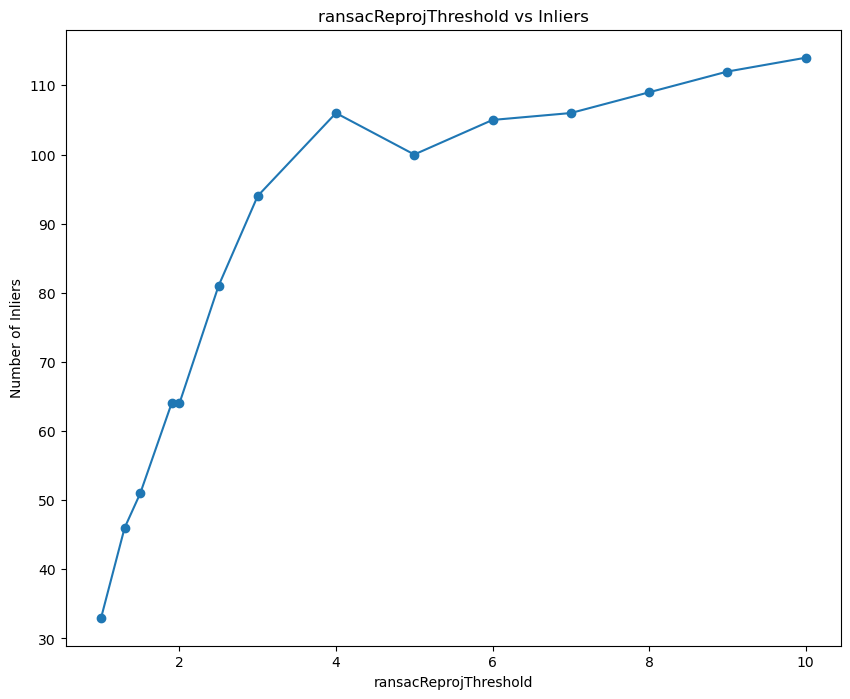

In [89]:
plt.plot(thresholds, inliers, marker='o')
plt.title("ransacReprojThreshold vs Inliers")
plt.xlabel("ransacReprojThreshold")
plt.ylabel("Number of Inliers")
plt.show()

***Explanation***

It can be observed that at the threshold 1, there are 33 inliers, while at threshold 10, there are 114 inliers. It can also be seen that generally, as the threshold increases, there would be more inliers as supported by the formula definition. A larger threhold means that there are more "far enough" pairs of keypoints, but this also means that the distance between the keypoints increase as the threshold increases. This might introduce more noise as threshold increases. A somewhat weak logarithmic trend can also be discovered as the change of inlier count from threshold 1 to 3 is drastically much larger than the inlier count from threshold 3 to 10. This shows that the inlier count will increase up until an extend and will reach a plateau. We observer that threshold 4 is close to treshold 10 and any value in this range can assume a good value we can choose from.

6. Finally, try matching several different image pairs from the data provided, including at least one success and one failure case. For the failure case, test and explain what step in the feature matching has failed, and try to improve it. Display and discuss your findings.
    1. Hint 1: In general, the book covers should be the easiest to match, while the landmarks are the hardest.
    2. Hint 2: Explain why you chose each example shown, and what parameter settings were used.
    3. Hint 3: Possible failure points include the feature detector, the feature descriptor, the matching strategy, or a combination of these.

In [ ]:
# Your results for other image pairs here

***Your explanation of results here***

# Question 2: What am I looking at? (40%)


<!--One application of feature matching is image retrieval. The goal of image retrieval is, given a query image of an object, to find all images in a database containing the same object, and return the results in ranked order (like a Google search). This is a huge research area but we will implement a very basic version of the problem based on the small dataset provided.-->

In this question, the aim is to identify an "unknown" object depicted in a query image, by matching it to multiple reference images, and selecting the highest scoring match. Since we only have one reference image per object, there is at most one correct answer. This is useful for example if you want to automatically identify a book from a picture of its cover, or a painting or a geographic location from an unlabelled photograph of it.

The steps are as follows:

1. Select a set of reference images and their corresponding query images. 

    1. Hint 1: Start with the book covers, or just a subset of them.
    3. Hing 2: This question can require a lot of computation to run from start to finish, so cache intermediate results (e.g. feature descriptors) where you can.
    
2. Choose one query image corresponding to one of your reference images. Use RANSAC to match your query image to each reference image, and count the number of inlier matches found in each case. This will be the matching score for that image.

3. Identify the query object. This is the identity of the reference image with the highest match score, or "not in dataset" if the maximum score is below a threshold.

4. Repeat steps 2-3 for every query image and report the overall accuracy of your method (that is, the percentage of query images that were correctly matched in the dataset). Discussion of results should include both overall accuracy and individual failure cases.

    1. Hint 1: In case of failure, what ranking did the actual match receive? If we used a "top-k" accuracy measure, where a match is considered correct if it appears in the top k match scores, would that change the result?

<!--Code to implement this algorithm should mostly be written in a supporting file such as a2code.py. Call your code and display outputs in the notebook below.--> 


In [ ]:
# Your code to identify query objects and measure search accuracy for data set here 



***Your explanation of what you have done, and your results, here***

5. Choose some extra query images of objects that do not occur in the reference dataset. Repeat step 4 with these images added to your query set. Accuracy is now measured by the percentage of query images correctly identified in the dataset, or correctly identified as not occurring in the dataset. Report how accuracy is altered by including these queries, and any changes you have made to improve performance.

In [ ]:
# Your code to run extra queries and display results here

***Your explanation of results and any changes made here***


6. Repeat step 4 and 5 for at least one other set of reference images from museum_paintings or landmarks, and compare the accuracy obtained. Analyse both your overall result and individual image matches to diagnose where problems are occurring, and what you could do to improve performance. Test at least one of your proposed improvements and report its effect on accuracy.


In [ ]:
# Your code to search images and display results here

***Your description of what you have done, and explanation of results, here***

# References

Lowe, D.G. Distinctive Image Features from Scale-Invariant Keypoints. International Journal of Computer Vision 60, 91–110 (2004). https://doi.org/10.1023/B:VISI.0000029664.99615.94